# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [99]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib as plt
import seaborn as sns
from pprint import pprint
from functions import save_pickle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score

In [100]:
# read in the json files
portfolio_raw = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_raw = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_raw = pd.read_json('data/transcript.json', orient='records', lines=True)

In [101]:
test_size = 0.15
seed = 42

## Define the problem

## Preprocessing

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

#### Portfolio data
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [102]:
portfolio_raw

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [103]:
portfolio = portfolio_raw.join(portfolio_raw.pop("channels").str.join("|").str.get_dummies())

In [104]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


#### Profile data

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [105]:
profile_raw.head(7)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN


In [106]:
profile_raw.shape

(17000, 5)

In [107]:
profile_raw.gender.value_counts(dropna=False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

In [108]:
profile_raw.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [109]:
profile_raw[profile_raw.gender.isna()].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The code above shows that everyone that did not fill in gender, did also not fill in income.

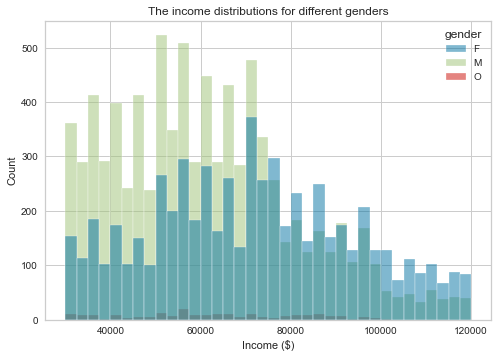

In [110]:
income_dist = sns.histplot(profile_raw, x='income', hue='gender');
income_dist.set(xlabel="Income ($)", title="The income distributions for different genders");

#### Transcript

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [111]:
transcript_raw.shape

(306534, 4)

In [112]:
transcript_raw.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [113]:
transcript_raw[transcript_raw.person=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [114]:
transcript_raw.event.value_counts(dropna=False)

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [115]:
# Split the json-like value column
transcript = transcript_raw.join(transcript_raw.value.apply(pd.Series))#.drop('value')

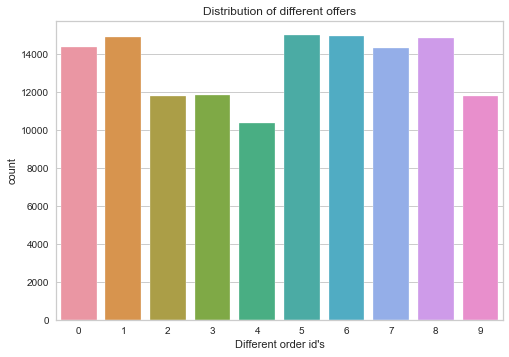

In [116]:
transcript_plot = transcript[~transcript["offer id"].isnull()].copy(deep=True)
transcript_plot = transcript_plot.merge(portfolio["id"].reset_index(), left_on="offer id", right_on="id")

diff_orders = sns.countplot(data=transcript_plot,x="index")
diff_orders.set(xlabel="Different order id's", title="Distribution of different offers");

In [117]:
# Merge the transcripts with the persons
transcript_persons = transcript.merge(profile_raw, left_on="person", right_on="id", how="outer")

In [118]:
# Combine the offer_id and the 'offer id' columns
transcript_persons["offer_id"] = transcript_persons["offer_id"].where(~transcript_persons["offer_id"].isna(), transcript_persons["offer id"])

In [119]:
# Only select the relevant columns
df = transcript_persons[['event', 'time', 'offer_id', 'amount', 'gender', 'age', 'became_member_on', 'income', 'person']]

In [120]:
# merge the transcripts, persons and portfolio
df_total = df.merge(portfolio, right_on="id", left_on="offer_id", how="outer")[['event', 'time', 'amount', 'gender', 'age', 'became_member_on', 'income', 'reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile', 'social', 'web', 'person', 'id']]

In [121]:
# rename id's for clarity
df_total.rename(columns={"id":"transaction_id", "person":"person_id"}, inplace=True)

In [122]:
# Duration in hours
df_total.duration = df_total.duration * 24

In [123]:
# Select the offers received, viewed and completed
offer_received = df_total[df_total.event=="offer received"]
offer_viewed = df_total[df_total.event=="offer viewed"][['person_id', 'transaction_id', 'time']]
offer_completed = df_total[df_total.event=="offer completed"][['person_id', 'transaction_id', 'time']]

# Add offers viewed to offers received
df_offer = offer_received.merge(offer_viewed, left_on=["person_id", "transaction_id"], right_on=["person_id", "transaction_id"], how="outer")
df_offer = df_offer.rename(columns={"time_x":"time_offer_received", "time_y":"time_offer_viewed"})
df_offer["time_offer_ended"] = df_offer.time_offer_received + df_offer.duration

# The offer is either seen within the period of receiving and ending OR the offer is not seen at all (null value)
df_offer = df_offer[((df_offer.time_offer_received <= df_offer.time_offer_viewed) & (df_offer.time_offer_viewed <= df_offer.time_offer_ended)) | (df_offer.time_offer_viewed.isna())]

In [124]:
# Merging the offer_completed
df_offer = df_offer.merge(offer_completed, left_on=["person_id", "transaction_id"], right_on=["person_id", "transaction_id"], how="outer")
df_offer.rename(columns={"time":"time_completed"}, inplace=True)
data = df_offer[((df_offer.time_offer_viewed <= df_offer.time_completed) & (df_offer.time_completed <= df_offer.time_offer_ended)) | (df_offer.time_completed.isna())]

In [125]:
# The age 118 is unlikely for so many people. We assume that it is a default value of some sorts.
data.age.where(data.age!=118, inplace=True)

## Analysis & Modelling

The purpose is to see what impacts offer completions.

### Feature engineering

<ul>
    <li>time_offer_viewed: Can not change influence this. Will be deleted. </li>
    <li>event, person_id, transaction_id, amount: deleted</li>
    <li>gender: nans will be filled with "unknown"</li>
    <li>time_completed: a target column willl be created. 0 if time_completed is nan, 1 else</li>
    <li>became_member_on: change to datetime and transform to amount of days member until the most recent date.</li>
</ul>

Rows with no income and age can be dropped to see if models perform better after.

In [126]:
data.columns

Index(['event', 'time_offer_received', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'person_id',
       'transaction_id', 'time_offer_viewed', 'time_offer_ended',
       'time_completed'],
      dtype='object')

In [127]:
data.head()

,event,time_offer_received,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web,person_id,transaction_id,time_offer_viewed,time_offer_ended,time_completed
0,offer received,0.0,NaN,F,75.0,20170509.0,100000.0,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,168.0,132.0
1,offer received,408.0,NaN,M,68.0,20180426.0,70000.0,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,420.0,576.0,522.0
2,offer received,504.0,NaN,None,NaN,20171002.0,NaN,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,68617ca6246f4fbc85e91a2a49552598,9b98b8c7a33c4b65b9aebfe6a799e6d9,648.0,672.0,NaN
4,offer received,408.0,NaN,M,65.0,20180209.0,53000.0,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,438.0,576.0,498.0
5,offer received,504.0,NaN,F,56.0,20180428.0,88000.0,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,d058f73bf8674a26a95227db098147b1,9b98b8c7a33c4b65b9aebfe6a799e6d9,522.0,672.0,NaN


In [128]:
data.shape

(64623, 20)

#### Delete unnecessary columns

In [129]:
# Delete columns
data = data.drop(columns=["time_offer_viewed", "event", "amount", "person_id", "transaction_id"])

#### Fill gender with unknown

In [130]:
# Fill gender
data.gender.fillna("Unknown", inplace=True)

#### Age Analysis

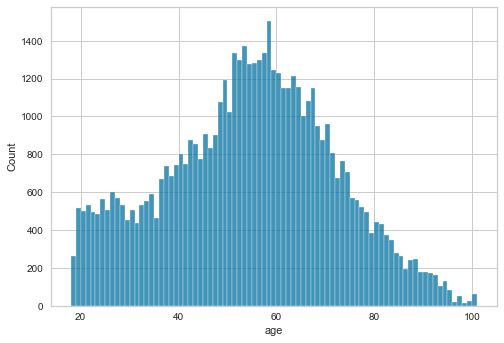

In [131]:
# Group ages
sns.histplot(data, x="age", bins=83); # 83 for every age 18 to 101

In [132]:
bins = [0, 18, 25, 35, 45, 55, 65, 70, 74, 80, 85, 90, 110]
age_bins = pd.cut(data.age, bins)
age_bins = age_bins.cat.add_categories("Unknown")
age_bins.fillna("Unknown", inplace=True)

# df_age = pd.get_dummies(age_bins).add_prefix("age_")
# data.pop("age")
# data = data.join(df_age)

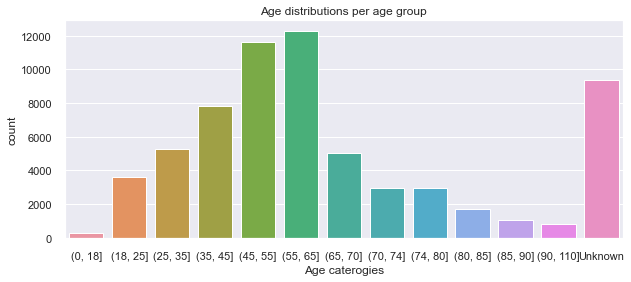

In [133]:
sns.set(rc={"figure.figsize":(10, 4)})
countplot = sns.countplot(age_bins, x='age');
countplot.set(xlabel="Age caterogies", title="Age distributions per age group");

#### Change became_member_on to year and month columns

I went for option 3 below, because that made the most sense to me. It felt like seasonality or years would provide less information than the amount of days somebody was a member. This of course could be researched in further modelling.

In [134]:
data.became_member_on.max()

20180726.0

In [135]:
# became_member_on
data.became_member_on = pd.to_datetime(data.became_member_on.astype(int), format="%Y%m%d")


# # Option 1: Became_member_on: to quarters
# df_member = pd.get_dummies(data.became_member_on.dt.to_period("Q")).add_prefix("member_")data.became_member_on = pd.to_datetime(data.became_member_on.astype(int), format="%Y%m%d").dt.to_period("Q")
# data.pop("became_member_on")
# data = data.join(df_member)

# Option 2: extract year and month
# data["became_member_year"] = data.became_member_on.dt.year
# data["became_member_month"] = data.became_member_on.dt.month
# data.pop("became_member_on");

# Option 3: amount of days already a member. Since the dataset is older we calculate the amount of days until the latest client
data['days_member'] = (data.became_member_on.max() - data.became_member_on).dt.days

data.pop("became_member_on");

#### Create Target variable

In [136]:
data["target"] = data["time_completed"]>0
data.pop("time_completed");

#### Fix column types

In [137]:
float_cols = ["time_offer_received", "reward", "difficulty", "duration", "email", "mobile", "social", "web", "time_offer_ended"]
data[float_cols] = data[float_cols].astype(int)

# Categoricals
cat_cols = ["gender", "offer_type"]
data[cat_cols] = data[cat_cols].astype("category")
data.dtypes

time_offer_received       int32
gender                 category
age                     float64
income                  float64
reward                    int32
difficulty                int32
duration                  int32
offer_type             category
email                     int32
mobile                    int32
social                    int32
web                       int32
time_offer_ended          int32
days_member               int64
target                     bool
dtype: object

#### Train test split

In [138]:
X = data.drop(columns="target")
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### Missing values

time_offer_viewed: null values, because the offers are not viewed. Not important for predictions because you can't influence this directly. You can indirectly through other means of communication.
time_completed: null values, because the offer is not completed. If it is empty the offer is not completed. If there is a completion time the offer is completed.
gender: fill with 'unknown' categorical value.
income: fill with median and create extra column with income unknown

#### Handle missing values income

In [139]:
# median income colum and extra column
X_train["income_missing"] = (X_train.income>0) == False
X_test["income_missing"] = (X_test.income>0) == False

median = X_train.income.median()
X_train.income.fillna(median, inplace=True)
X_test.income.fillna(median, inplace=True)

#### Handle missing values age

In [140]:
# median income colum and extra column
X_train["age_missing"] = (X_train.age>0) == False
X_test["age_missing"] = (X_test.age>0) == False

median = X_train.age.median()
X_train.age.fillna(median, inplace=True)
X_test.age.fillna(median, inplace=True)

In [141]:
X_train.age.fillna("Unknown", inplace=True)
X_test.age.fillna("Unknown", inplace=True)

In [142]:
assert X_train.isna().sum().sum() == 0, "There are null values in X_train"
assert X_test.isna().sum().sum() == 0, "There are null values in X_test"

#### One-Hot encoding

In [143]:
X_train.head()

,time_offer_received,gender,age,income,reward,difficulty,duration,offer_type,email,mobile,social,web,time_offer_ended,days_member,income_missing,age_missing
27120,336,M,46.0,68000.0,5,5,120,bogo,1,1,1,1,456,1650,False,False
66911,504,Unknown,55.0,62000.0,2,10,240,discount,1,1,1,1,744,518,True,True
15904,408,Unknown,55.0,62000.0,10,10,168,bogo,1,1,1,0,576,1367,True,True
62630,168,M,56.0,90000.0,2,10,240,discount,1,1,1,1,408,1529,False,False
77438,504,M,70.0,36000.0,3,7,168,discount,1,1,1,1,672,696,False,False


Categories are gender, offer_type,income_missing and age_missing

In [144]:
def oh_encoding(data, bin_cols=["income_missing", "age_missing"], cat_cols=["gender", "offer_type"]):

    data[bin_cols] = data[bin_cols].astype(int)

    encoder = OneHotEncoder()
    encoder.fit(data[cat_cols])

    cols = [feature.replace("x0", "gender").replace("x1", "offer") for feature in encoder.get_feature_names()]
    df = pd.DataFrame(encoder.fit_transform(data[cat_cols]).toarray(), columns=cols, index=data.index)
    # df.set_index(data.index)
    data.drop(columns=["gender", "offer_type"], inplace=True)
    data = data.join(df)
    return data

X_train = oh_encoding(X_train)
X_test = oh_encoding(X_test)

## Implementation

### Modeling

In [145]:
# Prepare data for pycaret
data["income_missing"] = (data.income>0) == False
data.income.fillna(median, inplace=True)
data.age.fillna("Unknown", inplace=True)

In [146]:
data.head()

,time_offer_received,gender,age,income,reward,difficulty,duration,offer_type,email,mobile,social,web,time_offer_ended,days_member,target,income_missing
0,0,F,75.0,100000.0,5,5,168,bogo,1,1,0,1,168,443,True,False
1,408,M,68.0,70000.0,5,5,168,bogo,1,1,0,1,576,91,True,False
2,504,Unknown,Unknown,55.0,5,5,168,bogo,1,1,0,1,672,297,False,True
4,408,M,65.0,53000.0,5,5,168,bogo,1,1,0,1,576,167,True,False
5,504,F,56.0,88000.0,5,5,168,bogo,1,1,0,1,672,89,False,False


#### Using PyCaret for exploration
Pycaret is used for a broad exploration what kind of model would work. The code below does not work in the same environment because of dependency errors.

The best model is a Random Forest with a close second place a LightGBM model. Hyper parameter tuning even yield a slightly worse model.

In [51]:
from pycaret.classification import *

reg = setup(data, target='target', train_size=0.80, categorical_features=["gender", "offer_type"],
            normalize=False, fold_strategy="kfold", fold=10, session_id=seed, log_experiment=False,
            remove_multicollinearity = True, multicollinearity_threshold = 0.9,)

,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(64623, 16)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [52]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8184,0.9036,0.7731,0.7701,0.7716,0.6208,0.6208,2.0900
lightgbm,Light Gradient Boosting Machine,0.8150,0.9046,0.7599,0.7707,0.7652,0.6125,0.6126,0.3240
gbc,Gradient Boosting Classifier,0.8110,0.9006,0.7630,0.7613,0.7622,0.6054,0.6054,2.5880
et,Extra Trees Classifier,0.8057,0.8894,0.7697,0.7479,0.7586,0.5960,0.5962,2.9200
ada,Ada Boost Classifier,0.8036,0.8938,0.7611,0.7482,0.7546,0.5909,0.5909,1.2640
dt,Decision Tree Classifier,0.7906,0.7816,0.7364,0.7361,0.7362,0.5626,0.5627,0.2700
lda,Linear Discriminant Analysis,0.7783,0.8674,0.7346,0.7145,0.7244,0.5390,0.5391,0.3340
ridge,Ridge Classifier,0.7782,0.0000,0.7313,0.7158,0.7234,0.5383,0.5384,0.1040
nb,Naive Bayes,0.7453,0.8450,0.8096,0.6420,0.7161,0.4906,0.5015,0.8640
knn,K Neighbors Classifier,0.7048,0.7551,0.6112,0.6326,0.6217,0.3798,0.3800,2.0480


In [53]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8186,0.9045,0.7673,0.7695,0.7684,0.6193,0.6193
1,0.8180,0.9033,0.7731,0.7567,0.7648,0.6164,0.6165
2,0.8141,0.9027,0.7558,0.7720,0.7638,0.6106,0.6107
3,0.8269,0.9100,0.7959,0.7760,0.7858,0.6406,0.6407
4,0.8226,0.9051,0.7789,0.7755,0.7772,0.6298,0.6299
5,0.8190,0.9025,0.7714,0.7810,0.7762,0.6242,0.6242
6,0.8273,0.9081,0.7860,0.7871,0.7865,0.6415,0.6415
7,0.8244,0.9105,0.7773,0.7773,0.7773,0.6323,0.6323
8,0.8151,0.9053,0.7630,0.7727,0.7678,0.6142,0.6142
9,0.8180,0.9016,0.7728,0.7656,0.7692,0.6189,0.6189


In [54]:
tuned_rf = tune_model(rf) # Tuning doesn't improve the model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7944,0.8930,0.8033,0.7104,0.7540,0.5785,0.5817
1,0.7911,0.8885,0.8014,0.6978,0.7460,0.5700,0.5740
2,0.7890,0.8873,0.7768,0.7165,0.7454,0.5657,0.5671
3,0.7969,0.8964,0.8173,0.7147,0.7626,0.5865,0.5905
4,0.7996,0.8929,0.7974,0.7253,0.7596,0.5885,0.5904
5,0.7925,0.8881,0.7975,0.7217,0.7577,0.5770,0.5792
6,0.8056,0.8983,0.8118,0.7355,0.7717,0.6032,0.6054
7,0.7965,0.8945,0.7970,0.7181,0.7555,0.5820,0.5844
8,0.7959,0.8930,0.7944,0.7235,0.7573,0.5819,0.5838
9,0.7942,0.8916,0.7979,0.7123,0.7527,0.5774,0.5801


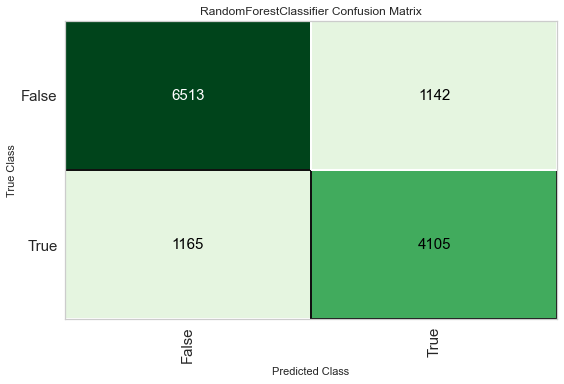

In [55]:
plot_model(rf, plot = 'confusion_matrix')

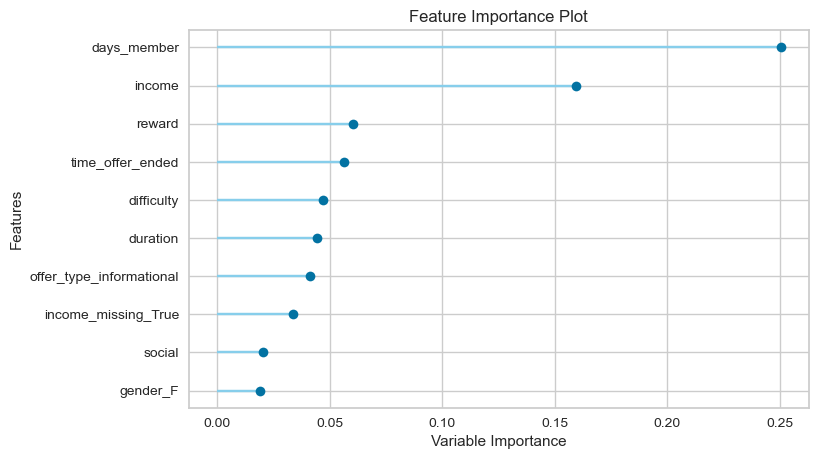

In [56]:
plot_model(rf, plot = 'feature')

## Create the random forest model

In [57]:
classifier = RandomForestClassifier(n_estimators=100)

In [58]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
y_pred = classifier.predict(X_test)

In [87]:
def print_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print("The scikit-learn RandomForests model metrics:")
    print(f"Accuracy: {acc}")
    print(f"Recall: {rec}")
    print(f"Precision: {precision}")
    print(f"f1-score: {f1}")
    return acc, rec, precision, f1

print_scores(y_test, y_pred);

The scikit-learn RandomForests model metrics:
Accuracy: 0.8105013410356922
Recall: 0.7595914299950174
Precision: 0.777607753124203
f1-score: 0.7684940138626339


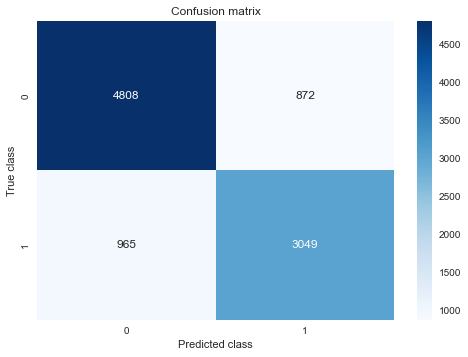

In [67]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_plot = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")
cf_plot.set(title="Confusion matrix", xlabel="Predicted class", ylabel="True class");

## Created the tuned model

In [147]:
# According to the different sources on the internet A RandomizedSearchCV would be the best approach.
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [148]:
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [71]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [72]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 33.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [74]:
from functions import save_pickle
save_pickle(rf_random, "model/rf_tuned.pkl")

In [77]:
y_pred_tuned = rf_random.predict(X_test)

In [81]:
print_scores(y_test, y_pred_tuned);

The scikit-learn RandomForests model metrics:
Accuracy: 0.818238085413658
Recall: 0.7700548081714002
f1-score: 0.778197381671702


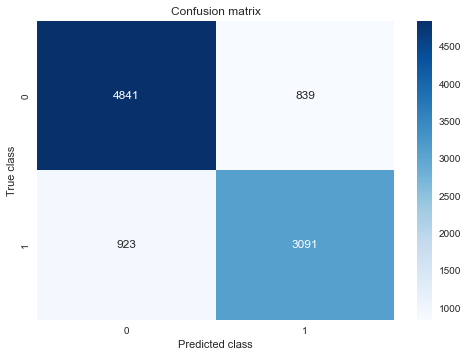

In [79]:
cf_matrix = confusion_matrix(y_test, y_pred_tuned)
cf_plot = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")
cf_plot.set(title="Confusion matrix", xlabel="Predicted class", ylabel="True class");

In [88]:
acc, rec, precision, f1 = print_scores(y_test, y_pred)
acc_tuned, rec_tuned, precision_tuned, f1_tuned = print_scores(y_test, y_pred_tuned)

The scikit-learn RandomForests model metrics:
Accuracy: 0.8105013410356922
Recall: 0.7595914299950174
Precision: 0.777607753124203
f1-score: 0.7684940138626339
The scikit-learn RandomForests model metrics:
Accuracy: 0.818238085413658
Recall: 0.7700548081714002
Precision: 0.7865139949109414
f1-score: 0.778197381671702


## Results

In [94]:
# Create the comparison chart
pd.DataFrame([[0.8204, 0.7742, 0.7733, 0.7737],[acc, rec, precision, f1], [acc_tuned, rec_tuned, precision_tuned, f1_tuned]], index=["PyCaret", "RandomForest", "Tuned RandomForest"], columns = ["Accuracy", "Recall", "Precision", "F1-Score"])

,Accuracy,Recall,Precision,F1-Score
PyCaret,0.820400,0.774200,0.773300,0.773700
RandomForest,0.810501,0.759591,0.777608,0.768494
Tuned RandomForest,0.818238,0.770055,0.786514,0.778197


### Sources & Inspiration

#### Preprocessing:
https://www.statology.org/one-hot-encoding-in-python/
https://stackoverflow.com/questions/56338847/how-to-give-column-names-after-one-hot-encoding-with-sklearn
https://medium.com/nerd-for-tech/difference-fit-transform-and-fit-transform-method-in-scikit-learn-b0a4efcab804

#### RandomForests
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html